In [100]:
import glob
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from natsort import natsorted
from scipy.stats import describe
from scipy.signal import filtfilt
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
import matplotlib

In [2]:
path = '/Users/patrick/Documents/phd/GitHub/tikhonov/'

In [4]:
g4iso_files = natsorted(glob.glob(path+"g4out/*KE_*_iso.csv"))
R = []
D = []

for i in range(5,len(g4iso_files)-101,1): # 100 keV to 1 MeV energy range in steps of 100 keV
    R.append(np.loadtxt(open(g4iso_files[i], "r"), delimiter=",",skiprows=9)[30:400:1,3]/5000000.0)
R = np.transpose(np.array(R))
RR = R
for j in range(0,370): # X-ray spectra from 0 to 600 keV
    if (np.linalg.norm(R[j,:] > 0)):
        D.append((1.0/np.linalg.norm(R[j,:]))) # Diagonal scaling as a left pre-conditioner
    else:
        D.append(1)

DD = np.diag(D)
RT = np.matmul(DD,R)

S = []
for k in range(0,R.shape[1]):
    #S.append(1.0/(k+1)**2) # right pre-conditioner towards an exponential
    S.append(1.0/np.sum(R[:,k]))
    #S.append(alexa_model_exp[k])
    #S.append(1)
SS = np.diag(S)
RS = np.matmul(RT,SS)

print('response condition number: ' + str(np.linalg.cond(R)))
print('response condition number after preconditioning: ' + str(np.linalg.cond(RS)))

elow_keV = 50
ehigh_keV = 1000
xspace_estep_keV = 1
espace_estep_keV = 10

espace = np.linspace(elow_keV,ehigh_keV,R.shape[1])
xspace = np.linspace(30,400,R.shape[0])

response condition number: 37962.37567316892
response condition number after preconditioning: 315.38372598636573


In [5]:
# generate synthetic data 

e0 = np.linspace(30, 299, R.shape[0])
e1 = np.linspace(100, ehigh_keV, R.shape[1])

def bg(total):
    beam = np.full(len(espace), 0)
    signal = np.full(len(xspace), 0)
    for e in range(0, e0.shape[0]): # normally distributed noise
        signal[e] = abs(signal[e] + np.random.normal(signal[e],np.sqrt(total/len(espace))))
    return((signal,beam))

def ex(fold, elow, ehigh, total):
    beam = np.exp(-e1/fold)
    beam[0:(np.abs(e1 - elow)).argmin()] = 0.0
    beam[(np.abs(e1 - ehigh)).argmin():-1] = 0.0
    integral = np.trapz(beam,e1)
    beam = beam*total/integral # beam should integrate to total e-/cm^2/s
    
    signal = np.matmul(R,beam)
    
    for e in range(0, e0.shape[0]):
        signal[e] = abs(signal[e] + np.random.normal(signal[e],np.sqrt(signal[e])))
        
    return(signal,beam)

def gauss(mu, sig, elow, ehigh, total):
    beam = total*np.exp(-np.power(e1 - mu, 2.) / (2 * np.power(sig, 2.)))
    beam[0:(np.abs(e1 - elow)).argmin()] = 0.0 # low and high energy cutoffs
    beam[(np.abs(e1 - ehigh)).argmin():-1] = 0.0
    integral = np.trapz(beam, x=e1)
    beam = beam*total/integral # beam should integrate to total e-/cm^2/s
    signal = np.matmul(R,beam)
    for e in range(0, e0.shape[0]): 
        signal[e] = np.random.normal(signal[e], scale=np.sqrt(signal[e]))
    return(signal,beam)

def mono(e, total):
    beam = np.full(e1.shape[0], 0.0)
    beam[(np.abs(e1 - e)).argmin()] = total
    signal = np.matmul(R,beam) # beam should integrate to total e-/cm^2/s
    for e in range(0, e0.shape[0]): 
        signal[e] = np.random.normal(signal[e], scale=np.sqrt(signal[e]))
    return((signal,beam))

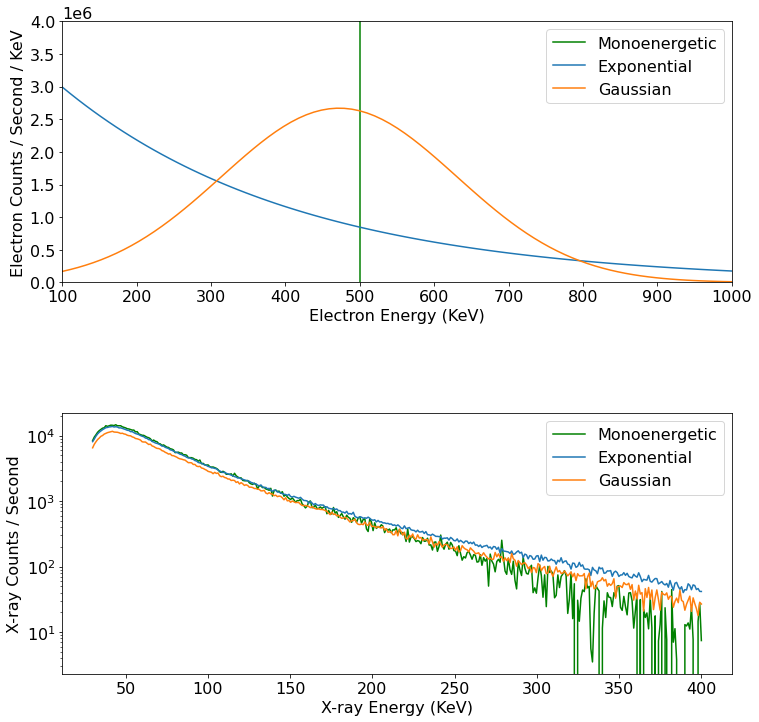

In [108]:
fig = plt.figure(figsize=(12,12))
gs = plt.GridSpec(nrows=2, ncols=1,hspace=.5,wspace=.3)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

beam_mono = mono(500,.14e9)
beam_exp = ex(300,0,1000,1e9)
beam_gauss = gauss(500,150,0,1100,1e9)

ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[0,0])

ax2.set_ylim([0,.4e7])
ax2.set_xlim([100,1000])


ax1.semilogy(xspace, beam_mono[0], color='green', label='Monoenergetic')
ax1.semilogy(xspace, beam_exp[0], label='Exponential')
ax1.semilogy(xspace, beam_gauss[0], label='Gaussian')

ax2.axvline(x=500,color='green', label='Monoenergetic')
ax2.plot(espace, beam_exp[1], label='Exponential')
ax2.plot(espace, beam_gauss[1], label='Gaussian')

ax1.set_xlabel('X-ray Energy (KeV)')
ax2.set_xlabel('Electron Energy (KeV)')


ax1.set_ylabel('X-ray Counts / Second')
ax2.set_ylabel('Electron Counts / Second / KeV')




ax2.legend()
ax1.legend()

plt.savefig('fig_0.pdf')  
